<a href="https://colab.research.google.com/github/wizard339/education/blob/main/classification_keras_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификатор Xception Network, реализованный на Keras и Tensorflow и обученный на датасете Cats and Dogs.
Может отличать фотографии с кошками от фотографий с собаками.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Несколько ячеек ниже: для скачивания и распаковки датасета в Colab в окружении на основе Linux.

Эти же ячейки можно выполнить на Windows, если необходимые утилиты (rm, ls, curl, unzip и пр.) будут установлены с помощью [Cygwin](https://cygwin.com/install.html).

Либо можно вручную скачать и распаковать датасет [Cats and Dogs](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip) на один уровень с ноутбуком.

In [ ]:
# Очищаем workspace от сохранённых обученных моделей от предыдущих запусков.
#!rm -rf xception_network_cats_and_dogs_checkpoints/
#!rm -rf xception_network_cats_and_dogs/

In [ ]:
# Очищаем workspace от скачанного файла от предыдущих запусков.
#!rm -f kagglecatsanddogs_3367a.zip

In [ ]:
# Очищаем workspace от распакованного датасета от предыдущих запусков.
#!rm -rf PetImages/

In [2]:
!uname -a

Linux 0d5816d02e17 5.10.133+ #1 SMP Fri Aug 26 08:44:51 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux


In [3]:
# Скачиваем датасет.
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  48.2M      0  0:00:16  0:00:16 --:--:-- 61.7M


In [ ]:
# Распаковываем датасет.
!unzip kagglecatsanddogs_5340.zip 'PetImages/**/*' -q

In [5]:
!ls

drive  kagglecatsanddogs_5340.zip  PetImages  sample_data


In [ ]:
!ls PetImages/Cat

In [ ]:
!ls PetImages/Dog

Завершили скачивание и распаковку датасета. Это можно сделать либо ячейками выше, либо вручную.

In [8]:
# Понадобится для работы с файлами.
import os

In [10]:
import tensorflow as tf

In [11]:
# Отфильтруем изображения, у которых в заголовке нет JFIF. Нам нужна информация о разрешении и соотношении сторон.
for folder_name in ("Cat", "Dog"):
  del_img_cnt = 0
  for file_name in os.listdir(f"PetImages/{folder_name}"):
    file_path = f"PetImages/{folder_name}/{file_name}"
    # Используем менеджер контекста (with) при чтении файла. Файл будет закрыт автоматически при выходе из блока кода.
    with open(file_path, "rb") as file:
      # Ищем в первых 4 байтах файла байты "JFIF" (в ASCII / UTF-8 кодах).
      has_jfif = tf.compat.as_bytes("JFIF") in file.peek(4)
      if not has_jfif:
        file.close()
        os.remove(file_path)
        del_img_cnt += 1
  print(f"Удалено {del_img_cnt} изображений из директории {folder_name}")

Удалено 759 изображений из директории Cat
Удалено 831 изображений из директории Dog


In [12]:
# Генерируем обучающую и валидационной выборки.
VALIDATION_SPLIT = 0.2
SEED = 1337
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 32

# Keras понимает, что 2 класса, потому что 2 директории (Cats, Dogs).
# Автоматически будут созданы два лейбла (0 - Cat, 1 - Dog).

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = VALIDATION_SPLIT,
    subset = "training",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

validation_images = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = VALIDATION_SPLIT,
    subset = "validation",
    seed = SEED,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


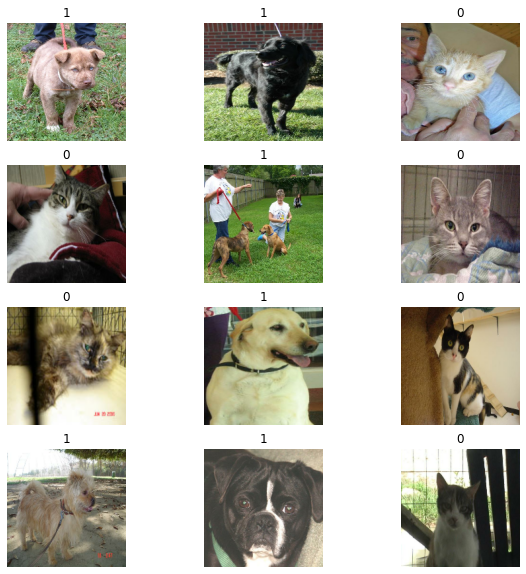

In [13]:
# Посмотрим на изображения.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_images.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [14]:
# Сделаем вспомогательную структуру для наращивания обучающей выборки.
augmentation_network = tf.keras.Sequential(
    [
        # Тоже слои, но реализуют детерминированные алгоритмы.
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

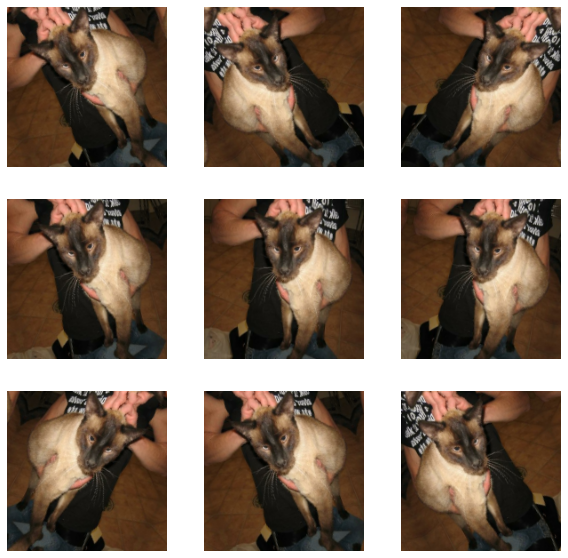

In [15]:
# Пример того, как она работает.
plt.figure(figsize=(10, 10))
for images, _ in training_images.take(1):
    for i in range(9):
        augmented_images = augmentation_network(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [16]:
# Нарастим обучающую выборку.
augmented_training_images = training_images.map(
  lambda image, label: (augmentation_network(image, training = True), label)
)

In [17]:
# Буферизируем ввод.
augmented_training_images = augmented_training_images.prefetch(buffer_size=32)
validation_images = validation_images.prefetch(buffer_size=32)

In [18]:
# Метод для создания модели Xception network.
def build_xception_network(input_shape, num_classes):
    inputs = tf.keras.Input(shape = input_shape)

    # Наращивание можно сделать частью архитектуры нейронной сети.
    #x = augmentation_network(inputs)

    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128, 256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])
        previous_block_activation = x

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)

In [19]:
# Создаём модель.
xception_network_cats_and_dogs = build_xception_network(input_shape = IMAGE_SIZE + (3,), num_classes = 2)

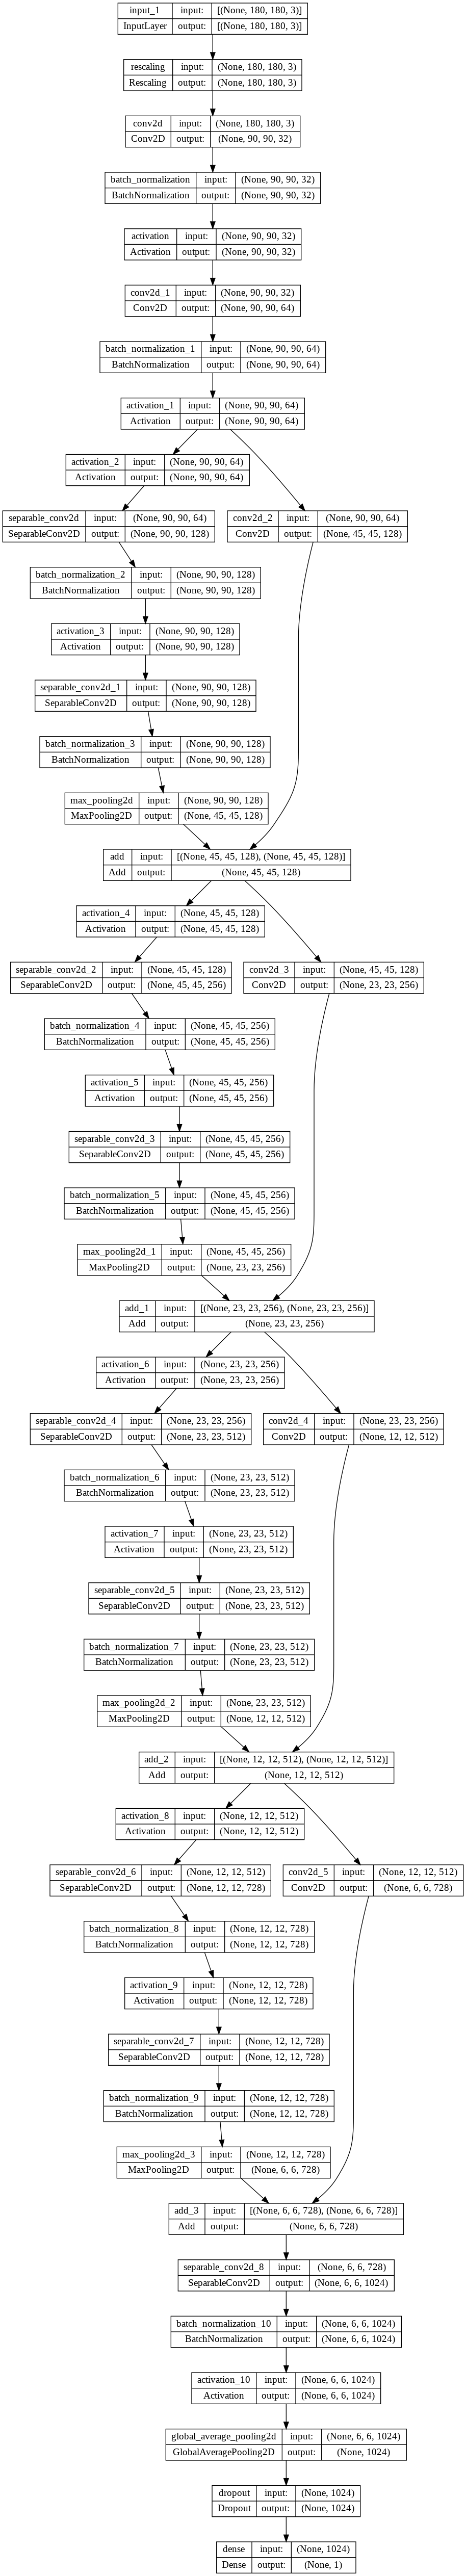

In [20]:
# Визуализируем её.
tf.keras.utils.plot_model(xception_network_cats_and_dogs, show_shapes = True)

In [ ]:
# Либо обучаем нейронную сеть.
# (!) Долгий процесс.
EPOCHS = 20

# callback для сохранения результатов обучения в формате Keras (h5) после каждой эпохи обучения.
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("xception_network_cats_and_dogs_checkpoints/epoch_{epoch}.h5")
]
xception_network_cats_and_dogs.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
xception_network_cats_and_dogs.fit(
    augmented_training_images, epochs=EPOCHS, callbacks=callbacks, validation_data=validation_images
)
# Сохраняем модель целиком в формате TensorFlow (saved_model.pb + variables/).
xception_network_cats_and_dogs.save("xception_network_cats_and_dogs");

In [ ]:
# Либо загружаем весовые коэффециенты от заранее обученной модели в формате Keras (h5).
xception_network_cats_and_dogs.load_weights('./epoch_50.h5')

In [29]:
!unzip xception_network_cats_and_dogs.zip

Archive:  xception_network_cats_and_dogs.zip
   creating: xception_network_cats_and_dogs/
   creating: xception_network_cats_and_dogs/assets/
  inflating: xception_network_cats_and_dogs/saved_model.pb  
   creating: xception_network_cats_and_dogs/variables/
  inflating: xception_network_cats_and_dogs/variables/variables.data-00000-of-00001  
  inflating: xception_network_cats_and_dogs/variables/variables.index  


In [30]:
# Либо загружаем заранее обученную модель целиком из формата TensorFlow (saved_model.pb + variables/).
xception_network_cats_and_dogs = tf.keras.models.load_model("xception_network_cats_and_dogs")

1/1 [==============================] - 1s 729ms/step
Score: [0.99998987]
С вероятностью 0.00 процентов на картинке изображена кошка, с вероятностью 100.00 процентов - собака.


(-0.5, 179.5, 179.5, -0.5)

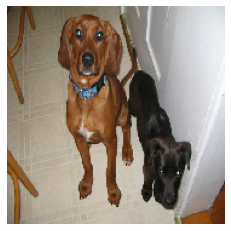

In [32]:
img = tf.keras.preprocessing.image.load_img(
    "/content/PetImages/Dog/89.jpg", target_size=IMAGE_SIZE
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = xception_network_cats_and_dogs.predict(img_array)
score = predictions[0]
print(f"Score: {score}")
print(
    "С вероятностью %.2f процентов на картинке изображена кошка, с вероятностью %.2f процентов - собака."
    % (100 * (1 - score), 100 * score)
)

plt.imshow(img)
plt.axis("off")

In [ ]:
!wget https://vladnews.ru/uploads/news/2016/11/11/thumb_94221_news_xxxl.jpg

--2022-06-02 17:10:17--  https://vladnews.ru/uploads/news/2016/11/11/thumb_94221_news_xxxl.jpg
Resolving vladnews.ru (vladnews.ru)... 89.108.104.42
Connecting to vladnews.ru (vladnews.ru)|89.108.104.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53771 (53K) [image/jpeg]
Saving to: ‘thumb_94221_news_xxxl.jpg’

thumb_94221_news_xx 100%[===================>]  52.51K   312KB/s    in 0.2s    

2022-06-02 17:10:18 (312 KB/s) - ‘thumb_94221_news_xxxl.jpg’ saved [53771/53771]

